In this notebook we will will discover how to develop *LSTM networks* in Python using the Keras deep learning library to predict the the lowest tendency of the bitcoin market in  given brands

the *input* :  brands where values are lower than the middle of Bollinger bands

the *output* : a score that shows us whether a point can be the lowest tendency or not 

**Import Libraries**


In [0]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

**Read json Data**

In [0]:
#contains the bands where candlestick are lower than the middle of bollinger band 
bands0 = pd.read_json (r'bands0.json')
bands1 = pd.read_json (r'bands1.json')
bands2 = pd.read_json (r'bands2.json')
bands4= pd.read_json (r'bands4.json')
bands5 = pd.read_json (r'bands5.json')


#contains bollinger bands with a period = 18 = 1h30
bollingerBands0 = pd.read_json (r'bollinger-bands0.json')
bollingerBands1 = pd.read_json (r'bollinger-bands1.json')
bollingerBands2 = pd.read_json (r'bollinger-bands2.json')
bollingerBands4= pd.read_json (r'bollinger-bands4.json')
bollingerBands5 = pd.read_json (r'bollinger-bands5.json')

#contains OHCLV for each candlestick
ohclv0 = pd.read_json (r'ohclv0.json')
ohclv1 = pd.read_json (r'ohclv1.json')
ohclv2 = pd.read_json (r'ohclv2.json')
ohclv4= pd.read_json (r'ohclv4.json')
ohclv5 = pd.read_json (r'ohclv5.json')

**Concatenate OHCLV datasets with their Bollinger Bands**

In [0]:
dataset0 = pd.concat([ohclv0, bollingerBands0], axis=1, sort=False)
dataset1 = pd.concat([ohclv1, bollingerBands1], axis=1, sort=False)
dataset2 = pd.concat([ohclv2, bollingerBands2], axis=1, sort=False)
dataset4 = pd.concat([ohclv4, bollingerBands4], axis=1, sort=False)
dataset5 = pd.concat([ohclv5, bollingerBands5], axis=1, sort=False)

frames1 = [dataset0, dataset1, dataset2,dataset4,dataset5]

#dataset that contains ohclv data and there bollingerBands
dataset = pd.concat(frames1)


**Cleaning Dataset**



*   delete useless columns
*   reset index of dataframe
*   renaming columns
*   drop nan and duplicates





In [6]:
del dataset[6]
del dataset[7]
dataset =dataset.reset_index(drop=True)

dataset.rename(columns={0:'timestamp', 1:'open',2:'high',3:'close',4:'low',5:'volume'}, inplace=True)
dataset =dataset.dropna()
dataset = dataset.drop_duplicates()

dataset.head()


,timestamp,open,high,close,low,volume,lower,middle,pb,upper
0,1566345600,9712.88,9721.28,9712.88,9712.92,0.376953,8996.666571,9063.965000,0.053296,9131.263429
1,1566345900,9714.67,9728.94,9714.67,9717.50,0.260442,8994.765371,9057.542778,0.156383,9120.320185
2,1566346200,9728.94,9728.94,9719.13,9728.94,2.487298,8995.278903,9051.505556,0.187199,9107.732208
3,1566346500,9728.94,9730.84,9713.05,9726.13,0.306041,8992.110983,9048.460556,0.265299,9104.810128
4,1566346800,9726.60,9726.60,9719.48,9719.48,0.039920,8989.426778,9044.952778,0.261078,9100.478778


**Concatenate all bands that represent the low tendencies**

where the candlestick close are lower than the middle of Bollinger bands

In [0]:
frames2 = [bands0, bands1, bands2,bands4,bands5]

bands = pd.concat(frames2)

bands= bands.reset_index(drop=True)



**Brands DataFrame Treatment** 


*   putting each brand in a dataframe
*   doing some cleaning 
*   add the label class which is called  : lowTrendScore that shows the score of each candle  , the more this score is near to 1 the more the candle present the lowest tendencies 




In [8]:
listDF=[]
for i in range(len(bands)):
  listDF.append(pd.DataFrame.from_items(zip(bands.iloc[i].index, bands.iloc[i].values)).T)
  
  del listDF[i][6]
  del listDF[i][7]
  listDF[i]=listDF[i].dropna()
  listDF[i].rename(columns={0:'timestamp', 1:'open',2:'high',3:'close',4:'low',5:'volume'}, inplace=True)
  
  listDF[i] = pd.merge(listDF[i], dataset,  how='left', left_on=['timestamp','open'	,'high'	,'close',	'low'	,'volume'], right_on = ['timestamp','open'	,'high'	,'close',	'low'	,'volume'])

  
  listDF[i]['lowTrendScore']= (listDF[i]['close'].min() / listDF[i]['close'] )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  This is separate from the ipykernel package so we can avoid doing imports until





*   concatenate all dataset in ListDF that represent the bands where the close candlstick lower than the middle of bollinger band
*   doing some cleaning
*   Split up the dataset into inputs and targets
*   Scaling data
*   Reshaping Training Data for LSTM



LSTMs are sensitive to the scale of the input data

the sequence of values is important. we will split the ordered dataset into train and test datasets

In [9]:
X_Scaler = MinMaxScaler()


#concatenate all the Dataframes which has been stocked in listDF
data = listDF[0]
for i in range(len(listDF)-1):
  df=data.append(listDF[i+1], ignore_index=True)
  data=df
  
  
data = data.drop_duplicates()
data = data.dropna()
del data['timestamp'] #timestamp is useless


# split into train and test sets

df_train= data[:len(data)-int(len(data)*0.2)]
df_test= data[len(data)-int(len(data)*0.2):]

#get the target class and the features 
train_X = df_train.iloc[0:,0:9]
train_y = df_train.iloc[0:,9:]
train_X =train_X.values
train_y =train_y.values


test_X = df_test.iloc[0:,0:9]
test_y = df_test.iloc[0:,9:]
test_X =test_X.values
test_y =test_y.values

#scaling
train_X = X_Scaler.fit_transform(train_X)
test_X = X_Scaler.fit_transform(test_X)

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


I picked a Recurrent Neural Network
*   **Building the model**
*   **compiling the model**
*   **Training the model**







**The network has :**

a visible layer with 10 input

a hidden layer with 4 LSTM  neurons

an output layer that makes a single value prediction

**Early stopping** will stop the model from training before reaching all epochs when the model stops improving. 

In [10]:
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=2)


num_units = 4 #number of hidden units in the LSTM cell 
activation_function = 'sigmoid'
optimizer = 'adam'
loss_function = 'mean_squared_error'
batch_size = 5
num_epochs = 100

# Initialize the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer

regressor.add(LSTM(units = num_units, activation = activation_function, input_shape=(None, 9)))
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = optimizer, loss = loss_function)

# Using the training set to train the model
regressor.fit(train_X, train_y, batch_size = batch_size, epochs = num_epochs, validation_split=0.2,callbacks=[early_stopping_monitor])


W0830 21:09:44.443703 140341281298304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 21:09:44.494139 140341281298304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 21:09:44.504520 140341281298304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 21:09:44.729664 140341281298304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0830 21:09:44.960384 140341281298304 deprecation.py:323

Train on 1422 samples, validate on 356 samples
Epoch 1/100
1422/1422 [==============================] - 2s 1ms/step - loss: 0.2080 - val_loss: 0.0101
Epoch 2/100
1422/1422 [==============================] - 1s 443us/step - loss: 0.0112 - val_loss: 0.0041
Epoch 3/100
1422/1422 [==============================] - 1s 453us/step - loss: 0.0055 - val_loss: 0.0027
Epoch 4/100
1422/1422 [==============================] - 1s 438us/step - loss: 0.0035 - val_loss: 0.0020
Epoch 5/100
1422/1422 [==============================] - 1s 421us/step - loss: 0.0028 - val_loss: 0.0018
Epoch 6/100
1422/1422 [==============================] - 1s 422us/step - loss: 0.0024 - val_loss: 0.0017
Epoch 7/100
1422/1422 [==============================] - 1s 422us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 8/100
1422/1422 [==============================] - 1s 439us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 9/100
1422/1422 [==============================] - 1s 431us/step - loss: 0.0019 - val_loss: 0.0013
Epoch 10/1

**make predictions**

**calculate root mean squared error**

In [15]:
# make predictions
trainPredict = regressor.predict(train_X)
testPredict = regressor.predict(test_X)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(train_y, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(test_y, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.38 RMSE


**Compare the predicted score with the Real score**


*   Manual comparison
*   Comparison with graph



In [16]:
#Manual comparison

#Using the Real Score : we want to print the index of the lowest trend : which is represented by a score = 1 
d1=pd.DataFrame(test_y)
print(d1.index[d1[0] ==1].tolist())


#Using the predicted Score : we want to print the index of the lowest trend : which is the nearest to 1 : which is the maximum value
d2 =pd.DataFrame(testPredict)
print(d2.index[d2[0] == d2[0].max()].tolist())

#we can get the 5 highest value which may be the lowest trend 
d2.nlargest(5, [0]) 

#we can see that the lowest trend is in index 196 as predicted , which is near to the trend point of index 197
#seems good

[184, 197]
[196]


,0
196,0.957654
197,0.950189
198,0.946091
239,0.934877
240,0.932956


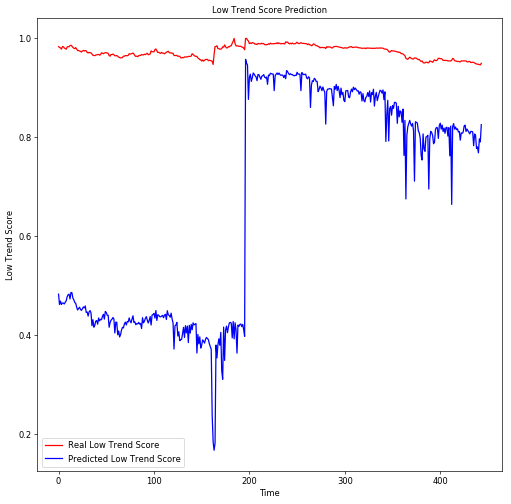

In [17]:
#Comparison with graph
plt.figure(figsize=(10, 10), dpi=60, facecolor = 'w', edgecolor = 'k')

plt.plot(test_y, color='red', label='Real Low Trend Score')
plt.plot(testPredict[:, 0], color = 'blue', label = 'Predicted Low Trend Score')
plt.title('Low Trend Score Prediction', fontsize = 10)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Low Trend Score', fontsize = 10)
plt.legend(loc = 'best')
plt.show()


**We could use python to calculate and plot the bollinger brands** 

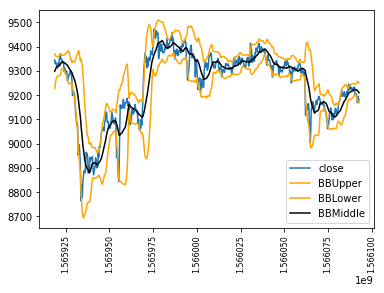

In [18]:
def addBollinger(df, period=18, col='close'):
   
    bbmid_series = df[col].rolling(window=period).mean()
    series_stdev = df[col].rolling(window=period).std()
    df['BBUpper'] = bbmid_series + 2*series_stdev
    df['BBLower'] = bbmid_series - 2*series_stdev
    df['BBBandwidth'] = df['BBUpper'] - df['BBLower']  
    df['BBMiddle'] = bbmid_series
    return df
  
  
  
del ohclv1[6]
del ohclv1[7]
ohclv1 =ohclv1.reset_index(drop=True)

ohclv1.rename(columns={0:'timestamp', 1:'open',2:'high',3:'close',4:'low',5:'volume'}, inplace=True)


test_asset = addBollinger(ohclv1)
#Bollinger Bands
fig, ax = plt.subplots()
ax.plot(test_asset['timestamp'][17:600], test_asset['close'][17:600])
ax.plot(test_asset['timestamp'][17:600], test_asset['BBUpper'][17:600], c='orange')
ax.plot(test_asset['timestamp'][17:600], test_asset['BBLower'][17:600], c='orange')
ax.plot(test_asset['timestamp'][17:600], test_asset['BBMiddle'][17:600], c='black')
plt.legend()
p = plt.setp(ax.xaxis.get_majorticklabels(), rotation=90, fontsize=8)


I thought about another alternative which is about setting all the dataset as the neural network input :
which contains  data of all OHCLV and all bollingers bands  
but gave me the same output

In [0]:
# I thought about another alternative , we can set all the dataset as the neural network input :
#which contains all data of all OHCLV and bollingers bands  
#that gave me the same output
  
  
'''data = listDF[0]
for i in range(len(listDF)-1):
  df=data.append(listDF[i+1], ignore_index=True)
  data=df
  
missedData =dataset[~dataset.timestamp.isin(data.timestamp)]

totalDF =missedData.append(data,ignore_index=True ,sort=False) 

totalDF['lowTrendScore'].loc[ (totalDF['lowTrendScore'].isnull())]=totalDF['lower']/totalDF['close']
totalDF'''

In [0]:
'''from sklearn.preprocessing import MinMaxScaler
X_Scaler = MinMaxScaler()


  
totalDF = data.drop_duplicates()
totalDF = data.dropna()
del totalDF['timestamp']


# split into train and test sets

df_train= totalDF[:len(totalDF)-int(len(totalDF)*0.2)]
df_test= totalDF[len(totalDF)-int(len(totalDF)*0.2):]

#get the target class and the features 
train_X = df_train.iloc[0:,0:9]
train_y = df_train.iloc[0:,9:]
train_X =train_X.values
train_y =train_y.values


test_X = df_test.iloc[0:,0:9]
test_y = df_test.iloc[0:,9:]
test_X =test_X.values
test_y =test_y.values

#scaling
train_X = X_Scaler.fit_transform(train_X)
test_X = X_Scaler.fit_transform(test_X)

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
'''